#Base model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchattacks

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)




In [5]:
pip install torchattacks


#model architecture

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:

model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()


Epoch 1
Epoch 1, Training Loss: 0.2296594690574954, Validation Loss: 0.06261551914181798
Epoch 2
Epoch 2, Training Loss: 0.055781291909515855, Validation Loss: 0.06366954947465119
Epoch 3
Epoch 3, Training Loss: 0.040749592119206986, Validation Loss: 0.04574827000590418
Epoch 4
Epoch 4, Training Loss: 0.0285523617285653, Validation Loss: 0.032893159764384144
Epoch 5
Epoch 5, Training Loss: 0.02388665343283598, Validation Loss: 0.04209964938668913
Epoch 6
Epoch 6, Training Loss: 0.02089429416297935, Validation Loss: 0.03359130001630779
Epoch 7
Epoch 7, Training Loss: 0.017448818528389285, Validation Loss: 0.03723129528355051
Epoch 8
Epoch 8, Training Loss: 0.015676593999264393, Validation Loss: 0.0443021757735628
Epoch 9
Epoch 9, Training Loss: 0.01380289112647976, Validation Loss: 0.04153173623788152
Epoch 10
Epoch 10, Training Loss: 0.010861955440863918, Validation Loss: 0.04132912633723847


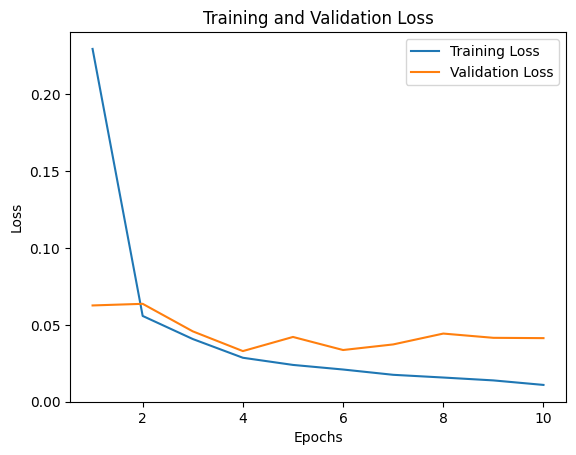

In [6]:

epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(epochs):
    print("Epoch", epoch+1)
    model.train()
    running_train_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss = criterion(output, labels)
            running_val_loss += val_loss.item()
    val_loss = running_val_loss / len(valloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")


plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images:', correct / total)

Accuracy of the network on the 10000 test images: 0.9903


#FGSM Attack

In [8]:


loss = nn.CrossEntropyLoss()


In [9]:
def fgsm_attack(model, loss, images, labels, eps):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()

    attack_images = images + eps * images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)

    return attack_images


In [10]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        outputs = model(data)
        _, pred_labels = torch.max(outputs, 1)
        adv_data= fgsm_attack(model, loss, data, target, epsilon)
        outputs = model(adv_data)
        _, predicted = torch.max(outputs, 1)

        if(predicted == target).all():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = adv_data.squeeze().detach().cpu().numpy()
                adv_examples.append(( pred_labels, predicted, adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = adv_data.squeeze().detach().cpu().numpy()
                adv_examples.append((pred_labels, predicted, adv_ex))

    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 39 / 157 = 0.2484076433121019
Epsilon: 0.01	Test Accuracy = 33 / 157 = 0.21019108280254778
Epsilon: 0.06	Test Accuracy = 16 / 157 = 0.10191082802547771
Epsilon: 0.09	Test Accuracy = 13 / 157 = 0.08280254777070063
Epsilon: 0.1	Test Accuracy = 12 / 157 = 0.07643312101910828
Epsilon: 0.2	Test Accuracy = 0 / 157 = 0.0


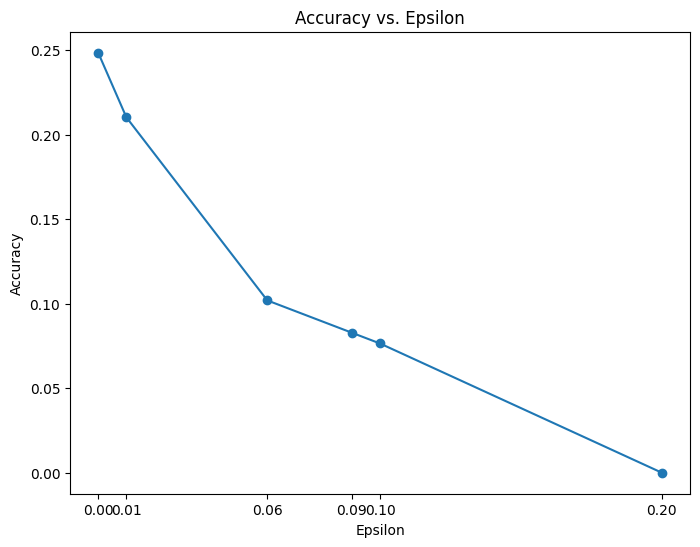

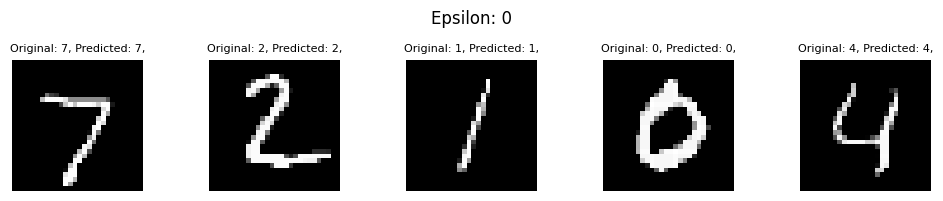

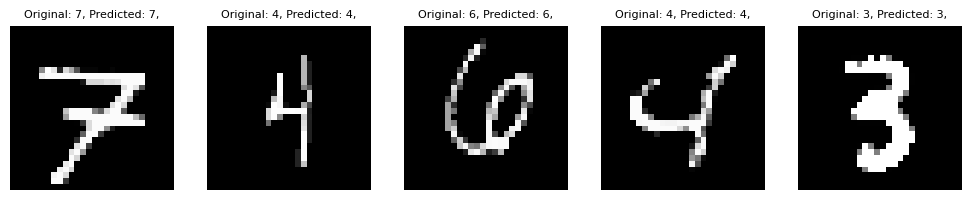

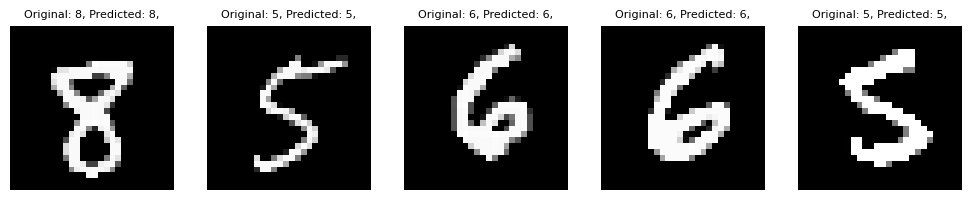

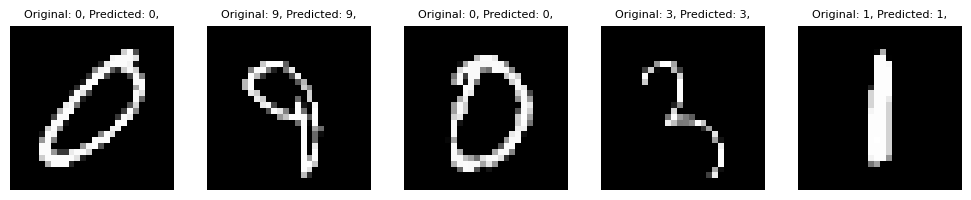

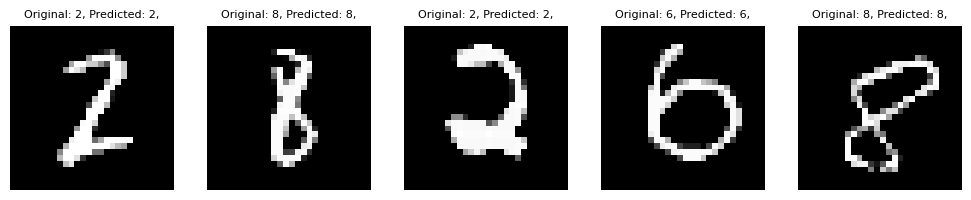

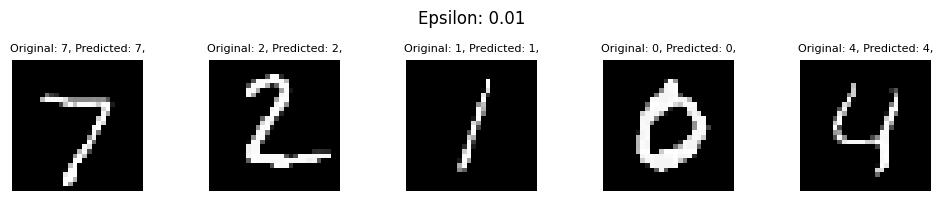

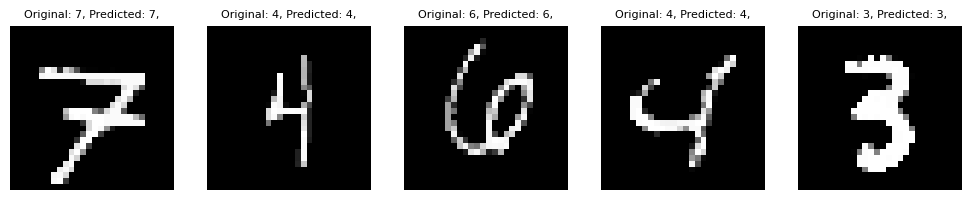

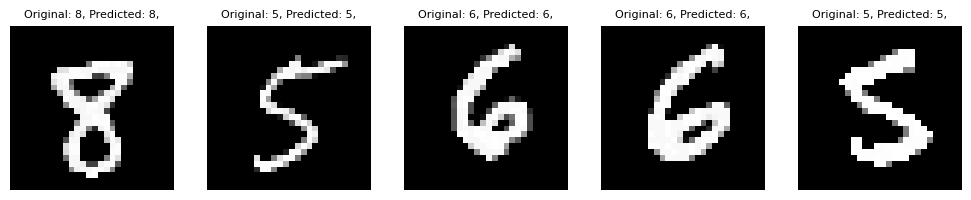

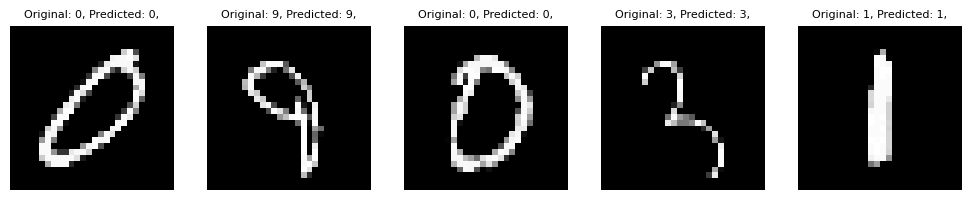

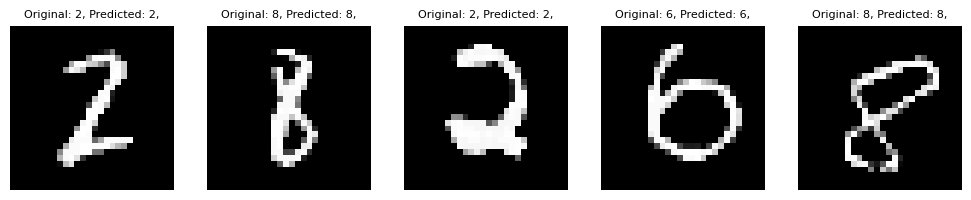

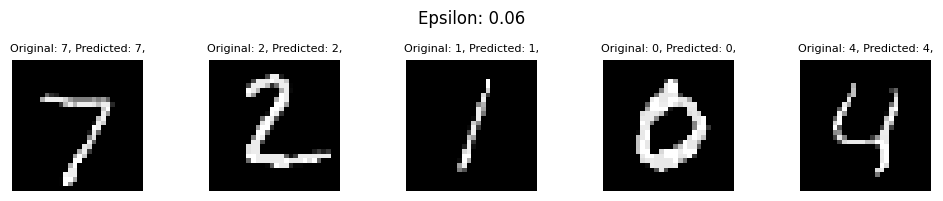

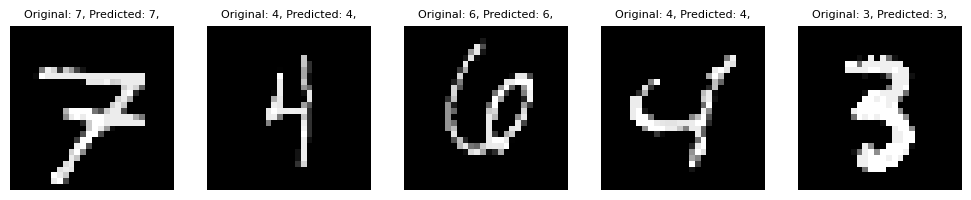

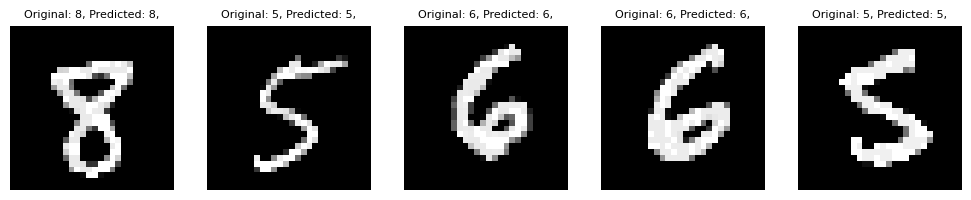

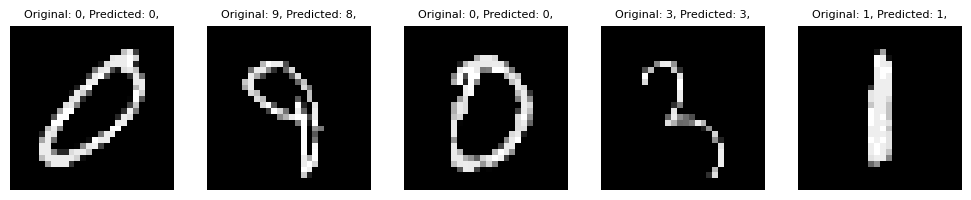

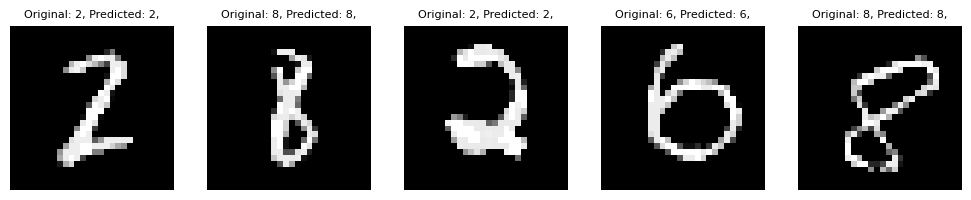

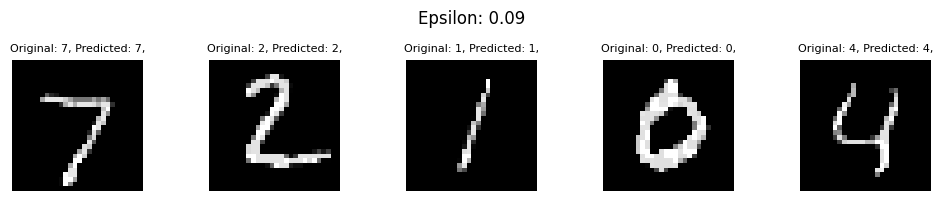

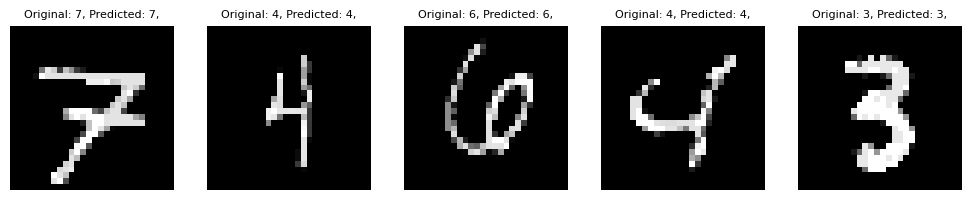

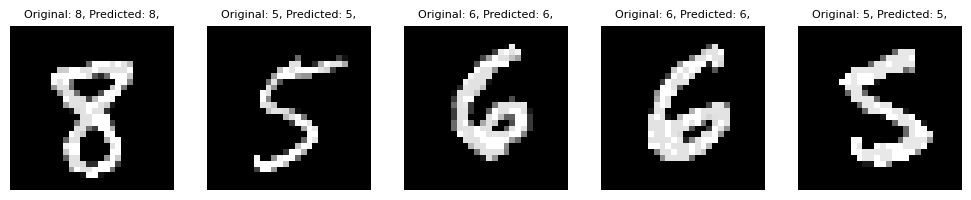

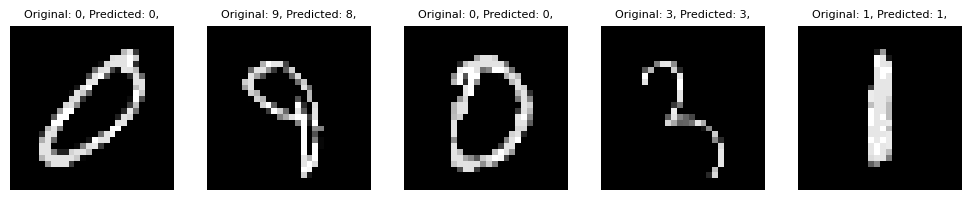

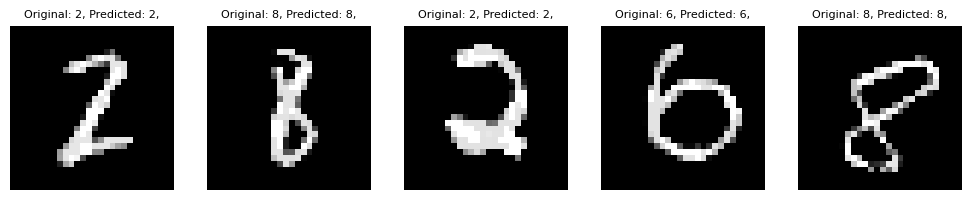

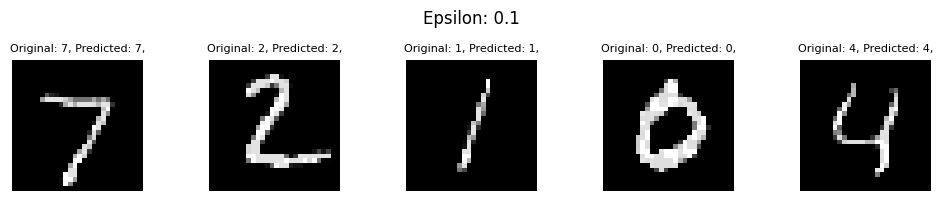

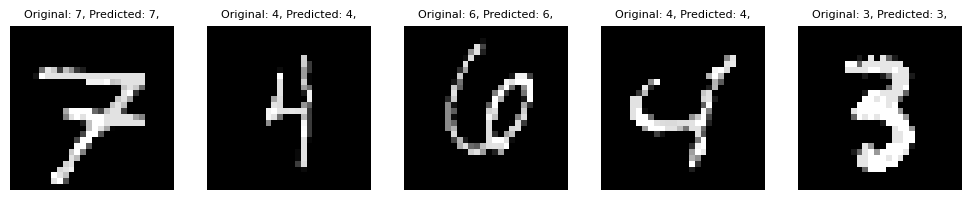

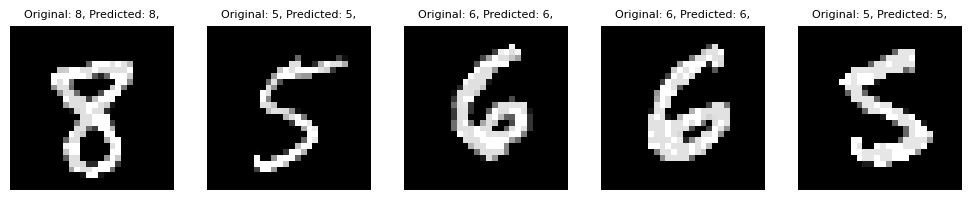

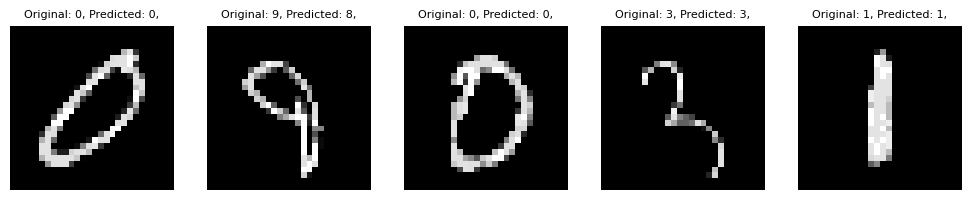

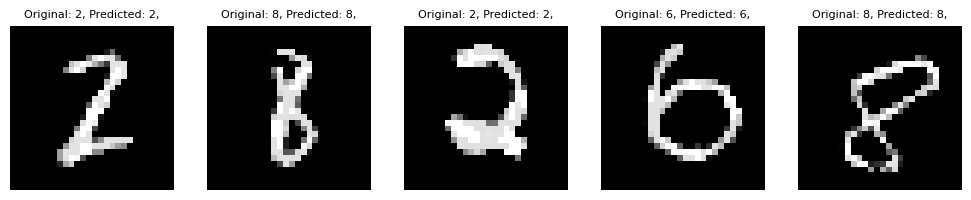

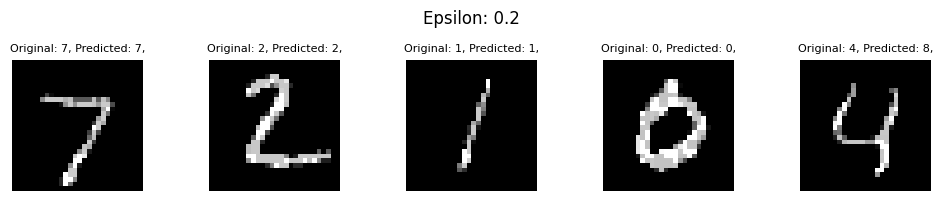

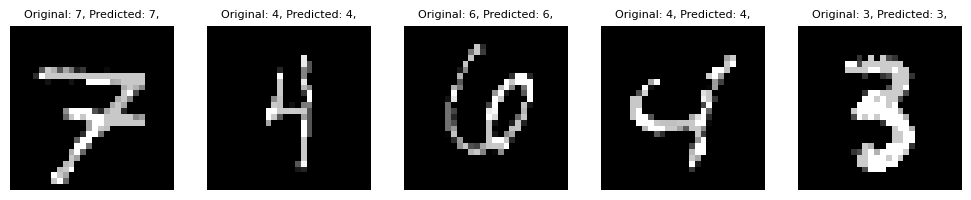

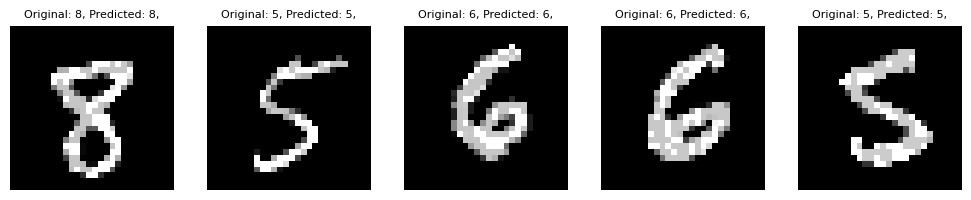

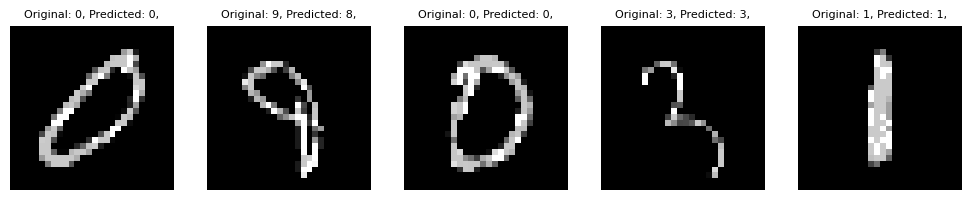

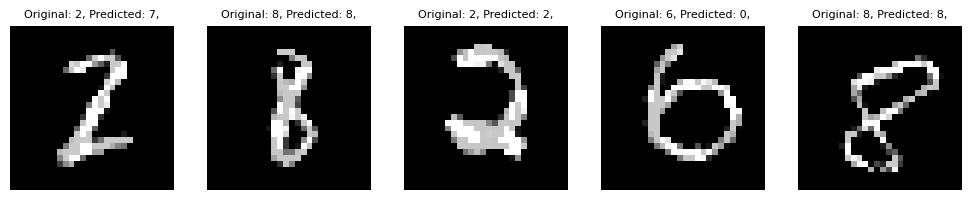

In [11]:
epsilons = [0,0.01,0.06,0.09,0.1,0.2]
accuracies = []
examples = []
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

plt.figure(figsize=(8, 6))
plt.plot(epsilons, accuracies, marker='o', linestyle='-')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon')
plt.xticks(epsilons)
plt.show()

for i in range(len(epsilons)):
    for j in range(min(5, len(examples[i]))):
        plt.figure(figsize=(10, 2))
        if j==0:
          plt.suptitle(f"Epsilon: {epsilons[i]}")
        orig, adv, ex_batch = examples[i][j]
        for k in range(min(5, ex_batch.shape[0])):
            plt.subplot(1, 5, k + 1)
            plt.imshow(ex_batch[k], cmap="gray")
            plt.title(f"Original: {orig[k]}, Predicted: {adv[k]},", fontsize=8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()







##Adversial training for fgsm

In [12]:
def train(model, device, train_loader, optimizer, criterion, epsilon):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        perturbed_data = fgsm_attack(model, criterion, data, target, epsilon)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        adv_output = model(perturbed_data)
        adv_loss = criterion(adv_output, target)
        adv_loss.backward()
        optimizer.step()

def defense_train(model, device, train_loader, test_loader, optimizer, criterion, epsilon, epochs):
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion, epsilon)
        test(model, device, test_loader, epsilon)


In [13]:
defense_train(model,device,trainloader,testloader,optimizer,criterion,0.3,20)

Epsilon: 0.3	Test Accuracy = 28 / 157 = 0.17834394904458598
Epsilon: 0.3	Test Accuracy = 30 / 157 = 0.1910828025477707
Epsilon: 0.3	Test Accuracy = 32 / 157 = 0.20382165605095542
Epsilon: 0.3	Test Accuracy = 36 / 157 = 0.22929936305732485
Epsilon: 0.3	Test Accuracy = 24 / 157 = 0.15286624203821655
Epsilon: 0.3	Test Accuracy = 46 / 157 = 0.2929936305732484
Epsilon: 0.3	Test Accuracy = 51 / 157 = 0.3248407643312102
Epsilon: 0.3	Test Accuracy = 40 / 157 = 0.25477707006369427
Epsilon: 0.3	Test Accuracy = 30 / 157 = 0.1910828025477707
Epsilon: 0.3	Test Accuracy = 42 / 157 = 0.267515923566879
Epsilon: 0.3	Test Accuracy = 44 / 157 = 0.2802547770700637
Epsilon: 0.3	Test Accuracy = 31 / 157 = 0.19745222929936307
Epsilon: 0.3	Test Accuracy = 50 / 157 = 0.3184713375796178
Epsilon: 0.3	Test Accuracy = 36 / 157 = 0.22929936305732485
Epsilon: 0.3	Test Accuracy = 43 / 157 = 0.27388535031847133
Epsilon: 0.3	Test Accuracy = 52 / 157 = 0.33121019108280253
Epsilon: 0.3	Test Accuracy = 38 / 157 = 0.242038

#pgd attack

In [3]:

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

Epoch 1
Epoch 1, Training Loss: 0.22885729289179046, Validation Loss: 0.08234348132998306
Epoch 2
Epoch 2, Training Loss: 0.05460220888862386, Validation Loss: 0.04796341779280176
Epoch 3
Epoch 3, Training Loss: 0.0386571277990782, Validation Loss: 0.03527042228218287
Epoch 4
Epoch 4, Training Loss: 0.028418022586692435, Validation Loss: 0.03305654305245782
Epoch 5
Epoch 5, Training Loss: 0.021096326965935684, Validation Loss: 0.03905920706459623
Epoch 6
Epoch 6, Training Loss: 0.020186889353198543, Validation Loss: 0.03354620082849424
Epoch 7
Epoch 7, Training Loss: 0.015787908907484962, Validation Loss: 0.037143912036512156
Epoch 8
Epoch 8, Training Loss: 0.012974039952469563, Validation Loss: 0.03690453276914845
Epoch 9
Epoch 9, Training Loss: 0.015188959516941394, Validation Loss: 0.03226966494937787
Epoch 10
Epoch 10, Training Loss: 0.00984493507409934, Validation Loss: 0.03882094950188517


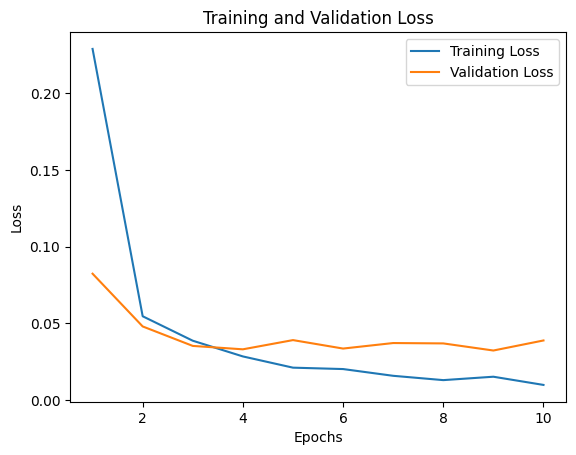

In [6]:
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(epochs):
    print("Epoch", epoch+1)
    model.train()
    running_train_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss = criterion(output, labels)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(valloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")


plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:

correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images without adversarial training: %.2f %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images without adversarial training: 99.10 %


In [4]:
def pgd_attack1(model, criterion, images, labels, epsilon=0.03, alpha=0.01, num_iter=40):
    perturbed_images = images.clone().detach()
    perturbed_images.requires_grad = True

    for i in range(num_iter):
        outputs = model(perturbed_images)
        loss = criterion(outputs, labels)
        loss.backward()

        with torch.no_grad():
            perturbed_images += alpha * perturbed_images.grad.sign()
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            perturbed_images = torch.clamp(perturbed_images, 0, 1)


        perturbed_images.grad.zero_()

    return perturbed_images


In [11]:
pgd_attack = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=20, random_start=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def evaluate_pgd_attack(model, criterion, test_loader, epsilon=0.03, alpha=0.01, num_iter=40):
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        model.to(images.device)
        perturbed_images = pgd_attack( images, labels)
        perturbed_images = perturbed_images.to(device)

        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print('Accuracy on PGD perturbed test set:', accuracy)
    return accuracy



epsilon = 0.03
alpha = 0.01
num_iter = 20

accuracy = evaluate_pgd_attack(model, criterion, testloader, epsilon, alpha, num_iter)


Accuracy on PGD perturbed test set: 0.1028


In [15]:
# Adversarial training
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        adversarial_inputs = pgd_attack(inputs, labels)
        outputs = model(adversarial_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training with adversarial training')


Finished Training with adversarial training


In [16]:
accuracy = evaluate_pgd_attack(model, criterion, testloader, epsilon, alpha, num_iter)

Accuracy on PGD perturbed test set: 0.9685


#Random pertubation attack

In [ ]:
def random_perturbation_attack(image_tensor, epsilon=0.1):
    device = image_tensor.device
    noise = torch.FloatTensor(image_tensor.size()).uniform_(-epsilon, epsilon).to(device)
    perturbed_image = image_tensor + noise
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


In [ ]:

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

Epoch 1
Epoch 1, Training Loss: 0.22885729289179046, Validation Loss: 0.08234348132998306
Epoch 2
Epoch 2, Training Loss: 0.05460220888862386, Validation Loss: 0.04796341779280176
Epoch 3
Epoch 3, Training Loss: 0.0386571277990782, Validation Loss: 0.03527042228218287
Epoch 4
Epoch 4, Training Loss: 0.028418022586692435, Validation Loss: 0.03305654305245782
Epoch 5
Epoch 5, Training Loss: 0.021096326965935684, Validation Loss: 0.03905920706459623
Epoch 6
Epoch 6, Training Loss: 0.020186889353198543, Validation Loss: 0.03354620082849424
Epoch 7
Epoch 7, Training Loss: 0.015787908907484962, Validation Loss: 0.037143912036512156
Epoch 8
Epoch 8, Training Loss: 0.012974039952469563, Validation Loss: 0.03690453276914845
Epoch 9
Epoch 9, Training Loss: 0.015188959516941394, Validation Loss: 0.03226966494937787
Epoch 10
Epoch 10, Training Loss: 0.00984493507409934, Validation Loss: 0.03882094950188517


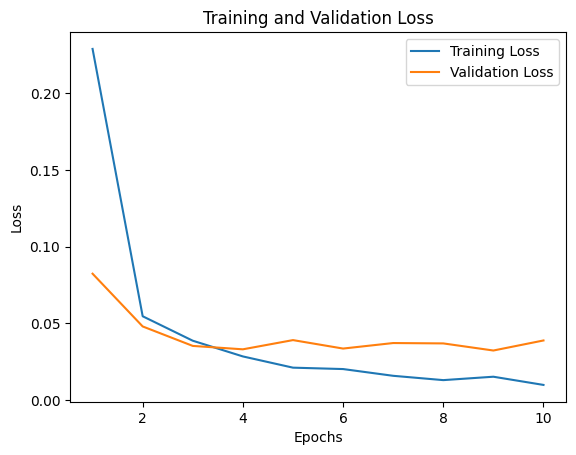

In [ ]:
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(epochs):
    print("Epoch", epoch+1)
    model.train()
    running_train_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss = criterion(output, labels)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(valloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")


plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
model.to(device)
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        perturbed_images = random_perturbation_attack(images, 0.1)

        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on perturbed test set:', correct / total)

Accuracy on perturbed test set: 0.1136


In [ ]:
epochs = 5#Adversial training
epsilon = 0.1
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        perturbed_images = random_perturbation_attack(images, epsilon)
        outputs = model(perturbed_images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}")


correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        perturbed_images = random_perturbation_attack(images, epsilon)
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on perturbed test set:', correct / total)


Epoch [1/5], Loss: 0.2737189902166525
Epoch [2/5], Loss: 0.07011976188669602
Epoch [3/5], Loss: 0.04747564818062044
Epoch [4/5], Loss: 0.03834366204993178
Epoch [5/5], Loss: 0.030371498909158013
Accuracy on perturbed test set: 0.9867
